In [18]:
import tensorflow as tf  # type: ignore
import numpy as np  # type: ignore
import PIL.Image  # type: ignore
from io import BytesIO
from IPython.display import display, Image  # type: ignore
import cv2  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
from scipy.signal import convolve  # type: ignore
from scipy.signal.windows import gaussian  # type: ignore

In [25]:
def display_array(a, fmt="jpeg", rng=[0, 1]):
    """Display an array as a picture."""
    a = (a - rng[0]) / float(rng[1] - rng[0]) * 255
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))


def load_and_resize_image(file_path, new_size=500):
    """Load and resize image maintaining aspect ratio."""
    img = PIL.Image.open(file_path)
    print(f"Loaded {file_path} ({img.size[0]}px x {img.size[1]}px)")

    if img.size[0] > 2000 or img.size[1] > 2000:
        print(f"Image too big ({img.size[0]} x {img.size[1]})")
        if img.size[0] > img.size[1]:
            ratio = new_size / img.size[0]
        else:
            ratio = new_size / img.size[1]
        print(f"Reducing by factor of {1./ratio:.2g}")
        img = img.resize(
            (int(img.size[0] * ratio), int(img.size[1] * ratio)), PIL.Image.ADAPTIVE
        )
        print(f"New size: ({img.size[0]} x {img.size[1]})")

    return img


def create_kernel(a):
    """Transform a 2D array or list into a convolution kernel."""
    a = np.asarray(a)
    a = a.reshape(list(a.shape) + [1, 1])
    return tf.constant(a, dtype=tf.float32)


def apply_convolution(x, kernel):
    """A simplified 2D convolution operation."""
    x = tf.expand_dims(tf.expand_dims(x, 0), -1)
    y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], padding="SAME")
    return y[0, :, :, 0]


def compute_gradient_x(x):
    """Compute the x gradient of an array."""
    gradient_x = create_kernel([[-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0]])
    return apply_convolution(x, gradient_x)


def compute_gradient_y(x):
    """Compute the y gradient of an array."""
    gradient_y = create_kernel([[-1.0, -1.0, -1.0], [0.0, 0.0, 0.0], [1.0, 1.0, 1.0]])
    return apply_convolution(x, gradient_y)


def detect_corners(x):
    """Find chess square corners in an array."""
    chess_corner = create_kernel([[-1.0, 0.0, 1.0], [0.0, 0.0, 0.0], [1.0, 0.0, -1.0]])
    return apply_convolution(x, chess_corner)


def dilate(x, size=3):
    """Dilate"""
    kernel = create_kernel(np.ones([size, size], dtype=np.float32))
    return tf.clip_by_value(apply_convolution(x, kernel), 1.0, 2.0) - 1.0


def erode(x, size=3):
    """Erode"""
    kernel = create_kernel(np.ones([size, size], dtype=np.float32))
    return tf.clip_by_value(
        apply_convolution(x, kernel), size * size - 1, size * size
    ) - (size * size - 1)


def opening(x, size=3):
    """Opening"""
    return dilate(erode(x, size), size)


def closing(x, size=3):
    """Closing"""
    return erode(dilate(x, size), size)


def skeletonize(x, size=3):
    """Skeletonize"""
    return tf.clip_by_value(erode(x) - opening(erode(x)), 0.0, 1.0)


def check_match(lineset):
    """Checks whether there exists 7 lines of consistent increasing order in set of lines."""
    linediff = np.diff(lineset)
    x = 0
    cnt = 0
    for line in linediff:
        if np.abs(line - x) < 5:
            cnt += 1
        else:
            cnt = 0
            x = line
    return cnt == 5


def prune_lines(lineset):
    """Prunes a set of lines to 7 in consistent increasing order (chessboard)."""
    linediff = np.diff(lineset)
    x = 0
    cnt = 0
    start_pos = 0
    for i, line in enumerate(linediff):
        if np.abs(line - x) < 5:
            cnt += 1
            if cnt == 5:
                end_pos = i + 2
                return lineset[start_pos:end_pos]
        else:
            cnt = 0
            x = line
            start_pos = i
    return lineset


def skeletonize_1d(arr):
    """Return skeletonized 1D array (thin to single value, favor to the right)."""
    _arr = arr.copy()
    for i in range(_arr.size - 1):
        if arr[i] <= _arr[i + 1]:
            _arr[i] = 0
    for i in np.arange(_arr.size - 1, 0, -1):
        if _arr[i - 1] > _arr[i]:
            _arr[i] = 0
    return _arr


def find_lines(hdx, hdy, hdx_thresh, hdy_thresh):
    """Returns pixel indices for the 7 internal chess lines in x and y axes."""
    gausswin = gaussian(21, 4)
    gausswin /= np.sum(gausswin)
    blur_x = convolve(hdx > hdx_thresh, gausswin, mode="same")
    blur_y = convolve(hdy > hdy_thresh, gausswin, mode="same")
    skel_x = skeletonize_1d(blur_x)
    skel_y = skeletonize_1d(blur_y)
    lines_x = np.where(skel_x)[0]
    lines_y = np.where(skel_y)[0]
    lines_x = prune_lines(lines_x)
    lines_y = prune_lines(lines_y)
    is_match = (
        len(lines_x) == 7
        and len(lines_y) == 7
        and check_match(lines_x)
        and check_match(lines_y)
    )
    return lines_x, lines_y, is_match


def extract_chessboard(img, lines_x, lines_y):
    """Extract the chessboard region from the original image."""
    x1, x2 = lines_x[0] - (lines_x[1] - lines_x[0]), lines_x[-1] + (
        lines_x[-1] - lines_x[-2]
    )
    y1, y2 = lines_y[0] - (lines_y[1] - lines_y[0]), lines_y[-1] + (
        lines_y[-1] - lines_y[-2]
    )
    x1, x2 = max(x1, 0), min(x2, img.size[0])
    y1, y2 = max(y1, 0), min(y2, img.size[1])
    chessboard_img = img.crop((x1, y1, x2, y2)).convert("RGB")
    return chessboard_img


def get_chess_tiles(a, lines_x, lines_y):
    """Split up input grayscale array into 64 tiles stacked in a 3D matrix using the chess linesets."""
    stepx = np.int32(np.round(np.mean(np.diff(lines_x))))
    stepy = np.int32(np.round(np.mean(np.diff(lines_y))))
    padr_x, padl_x, padr_y, padl_y = 0, 0, 0, 0
    if lines_x[0] - stepx < 0:
        padl_x = np.abs(lines_x[0] - stepx)
    if lines_x[-1] + stepx > a.shape[1] - 1:
        padr_x = np.abs(lines_x[-1] + stepx - a.shape[1])
    if lines_y[0] - stepy < 0:
        padl_y = np.abs(lines_y[0] - stepy)
    if lines_y[-1] + stepx > a.shape[0] - 1:
        padr_y = np.abs(lines_y[-1] + stepy - a.shape[0])
    a2 = np.pad(a, ((padl_y, padr_y), (padl_x, padr_x)), mode="edge")
    setsx = np.hstack([lines_x[0] - stepx, lines_x, lines_x[-1] + stepx]) + padl_x
    setsy = np.hstack([lines_y[0] - stepy, lines_y, lines_y[-1] + stepy]) + padl_y
    a2 = a2[setsy[0] : setsy[-1], setsx[0] : setsx[-1]]
    setsx -= setsx[0]
    setsy -= setsy[0]
    squares = np.zeros([stepy, stepx, 64], dtype=np.uint8)
    for i in range(8):
        for j in range(8):
            x1, x2 = setsx[i], setsx[i + 1]
            y1, y2 = setsy[j], setsy[j + 1]
            padr_x, padl_x, padr_y, padl_y = 0, 0, 0, 0
            if (x2 - x1) > stepx:
                if i == 7:
                    x1 = x2 - stepx
                else:
                    x2 = x1 + stepx
            elif (x2 - x1) < stepx:
                if i == 7:
                    padr_x = stepx - (x2 - x1)
                else:
                    padl_x = stepx - (x2 - x1)
            if (y2 - y1) > stepy:
                if j == 7:
                    y1 = y2 - stepy
                else:
                    y2 = y1 + stepy
            elif (y2 - y1) < stepy:
                if j == 7:
                    padr_y = stepy - (y2 - y1)
                else:
                    padl_y = stepy - (y2 - y1)
            squares[:, :, (7 - j) * 8 + i] = np.pad(
                a2[y1:y2, x1:x2], ((padl_y, padr_y), (padl_x, padr_x)), mode="edge"
            )
    return squares


def detect_rotation_angle(image):
    """Detect the rotation angle of the chessboard in the image."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

    if lines is None:
        return 0

    angles = []
    for rho, theta in lines[:, 0]:
        angle = np.degrees(theta)
        angles.append(angle)

    median_angle = np.median(angles)
    return median_angle - 90 if median_angle > 45 else median_angle


def rotate_image(image, angle):
    """Rotate the image by the given angle using bicubic interpolation."""
    image_center = tuple(np.array(image.size) / 2)
    rotated_image = image.rotate(angle, resample=PIL.Image.BICUBIC, center=image_center, expand=True)
    return rotated_image


In [31]:
img_file = "test_web.png"
img_file = "dataset/chessboards/board_ffaa0b4957e2400c8f2d746bad48c3a8.png"
folder = "."
img = load_and_resize_image(f"{folder}/{img_file}")

Loaded ./dataset/chessboards/board_ffaa0b4957e2400c8f2d746bad48c3a8.png (782px x 1124px)


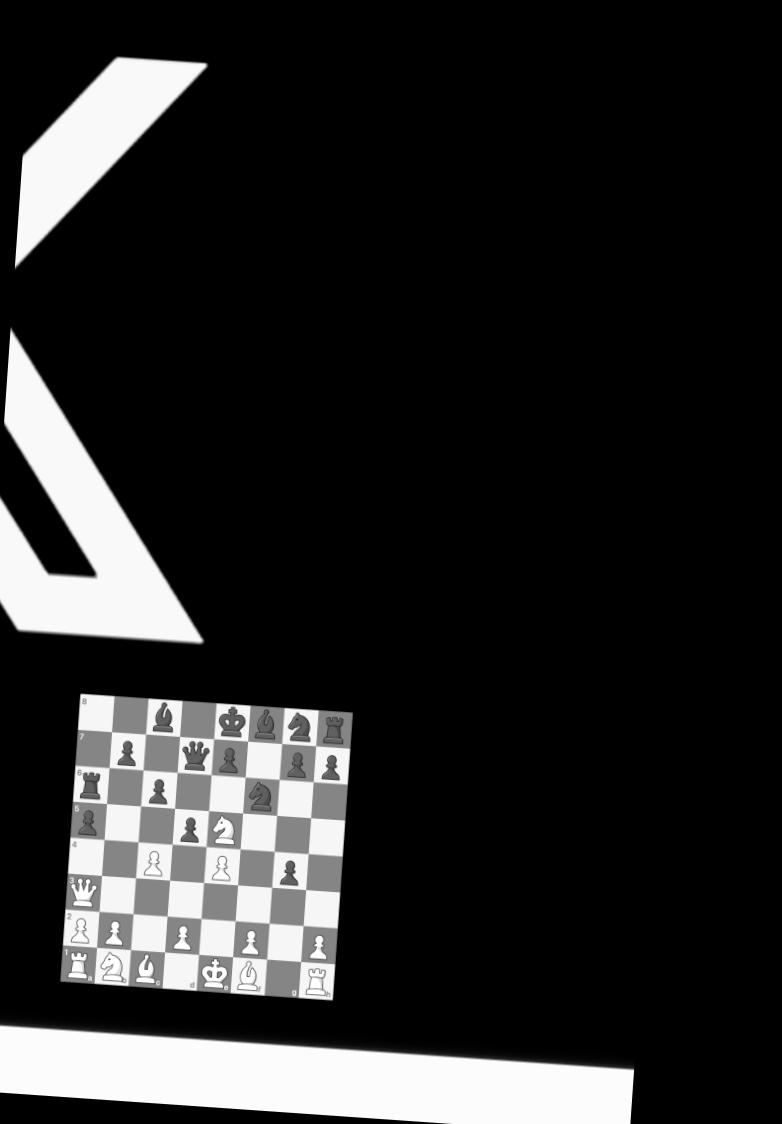

Detected rotation angle: 4.00 degrees


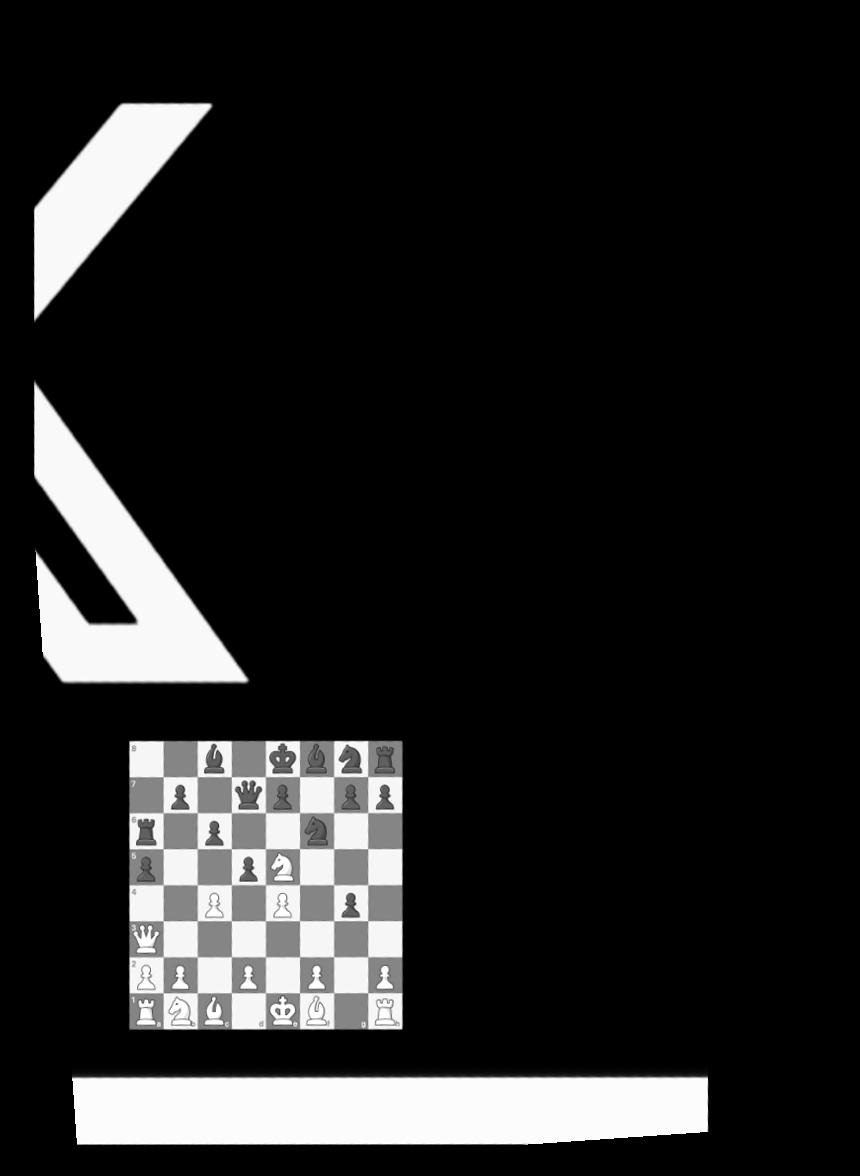

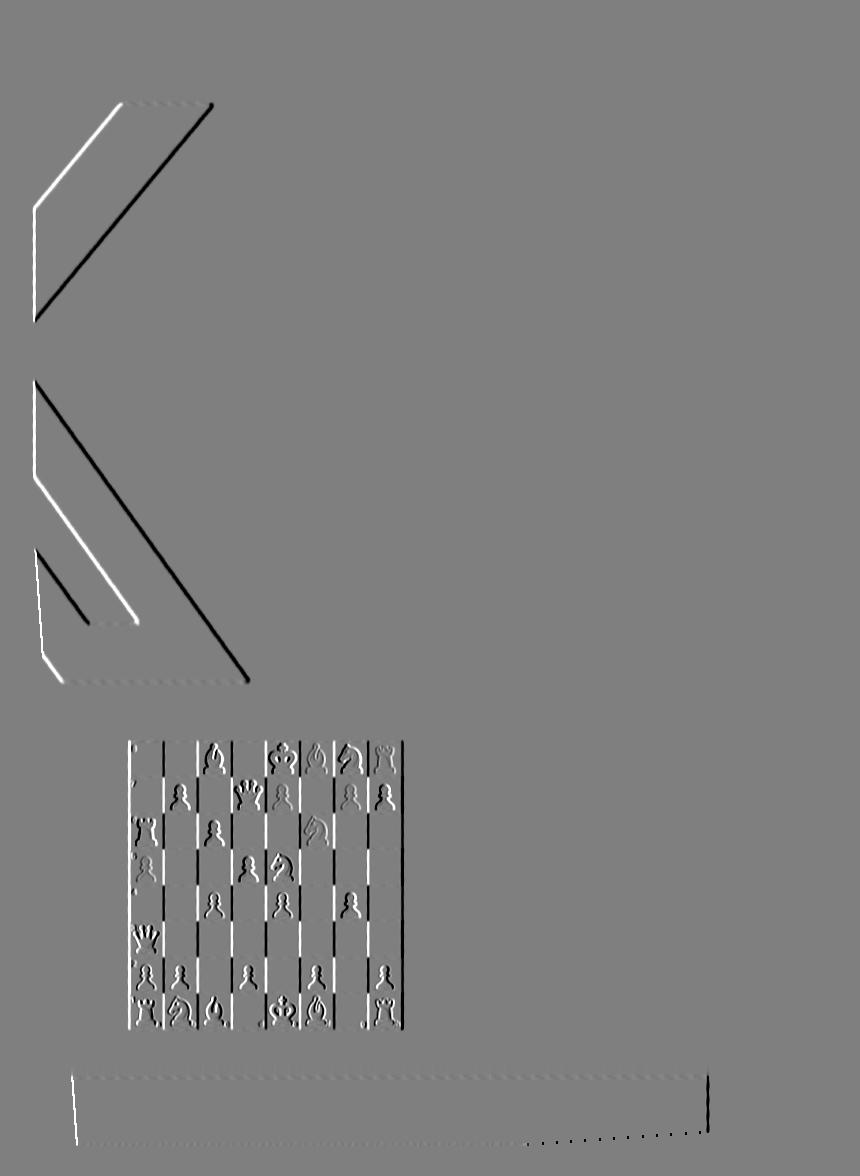

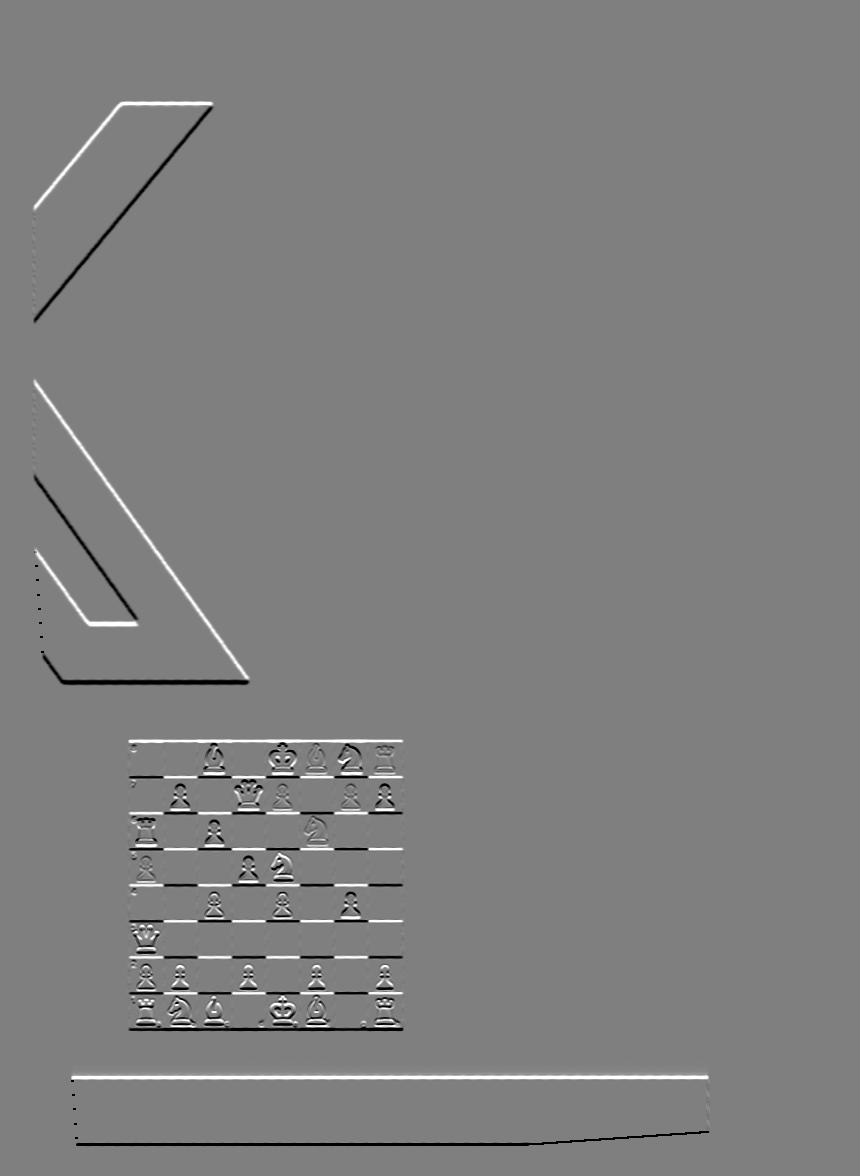

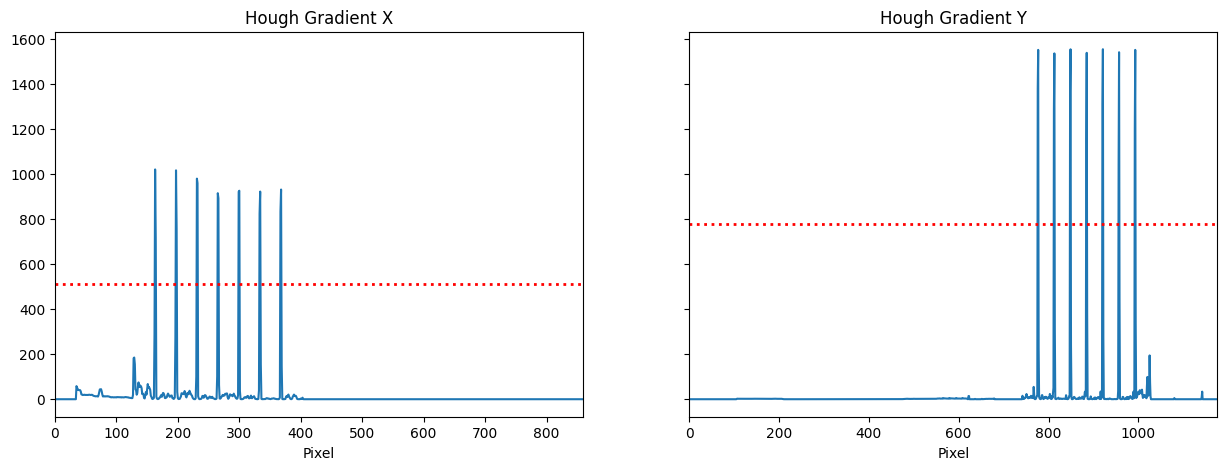

In [32]:
a = np.asarray(img.convert("L"), dtype=np.float32)
display_array(a, rng=[0, 255])

# Convert PIL image to OpenCV format
img_cv = np.array(img)
img_cv = img_cv[:, :, ::-1].copy()

# Detect rotation angle and rotate image
angle = detect_rotation_angle(img_cv)
print(f"Detected rotation angle: {angle:.2f} degrees")
if abs(angle) > 0.1:
    img = rotate_image(img, angle)
    a = np.asarray(img.convert("L"), dtype=np.float32)

display_array(a, rng=[0, 255])

A = tf.Variable(a)

Dx = compute_gradient_x(A)
Dy = compute_gradient_y(A)

Dx_val = Dx.numpy()
Dy_val = Dy.numpy()

display_array(Dx_val, rng=[-255, 255])
display_array(Dy_val, rng=[-255, 255])

Dx_pos = tf.clip_by_value(Dx, 0.0, 255.0, name="dx_positive")
Dx_neg = tf.clip_by_value(Dx, -255.0, 0.0, name="dx_negative")
Dy_pos = tf.clip_by_value(Dy, 0.0, 255.0, name="dy_positive")
Dy_neg = tf.clip_by_value(Dy, -255.0, 0.0, name="dy_negative")

hough_Dx = (
    tf.reduce_sum(Dx_pos, 0) * tf.reduce_sum(-Dx_neg, 0) / (a.shape[0] * a.shape[0])
)
hough_Dy = (
    tf.reduce_sum(Dy_pos, 1) * tf.reduce_sum(-Dy_neg, 1) / (a.shape[1] * a.shape[1])
)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))

# TODO: adjust threshold
hough_Dx_thresh = tf.reduce_max(hough_Dx) * 2.5 / 5
hough_Dy_thresh = tf.reduce_max(hough_Dy) * 2.5 / 5

hough_Dx_val = hough_Dx.numpy()
hough_Dx_thresh_val = hough_Dx_thresh.numpy()
hough_Dy_val = hough_Dy.numpy()
hough_Dy_thresh_val = hough_Dy_thresh.numpy()

ax1.plot(hough_Dx_val)
ax1.axhline(hough_Dx_thresh_val, lw=2, linestyle=":", color="r")
ax1.set_title("Hough Gradient X")
ax1.set_xlabel("Pixel")
ax1.set_xlim(0, a.shape[1])

ax2.plot(hough_Dy_val)
ax2.axhline(hough_Dy_thresh_val, lw=2, linestyle=":", color="r")
ax2.set_title("Hough Gradient Y")
ax2.set_xlim(0, a.shape[0])
ax2.set_xlabel("Pixel")

lines_x, lines_y, is_match = find_lines(
    hough_Dx_val.flatten(),
    hough_Dy_val.flatten(),
    hough_Dx_thresh_val,
    hough_Dy_thresh_val,
)

In [33]:
print("X", lines_x, np.diff(lines_x))
print("Y", lines_y, np.diff(lines_y))

if is_match:
    print("Chessboard found")
else:
    print("Couldn't find Chessboard")

X [164 198 232 266 300 334 368] [34 34 34 34 34 34]
Y [777 813 849 885 921 957 993] [36 36 36 36 36 36]
Chessboard found


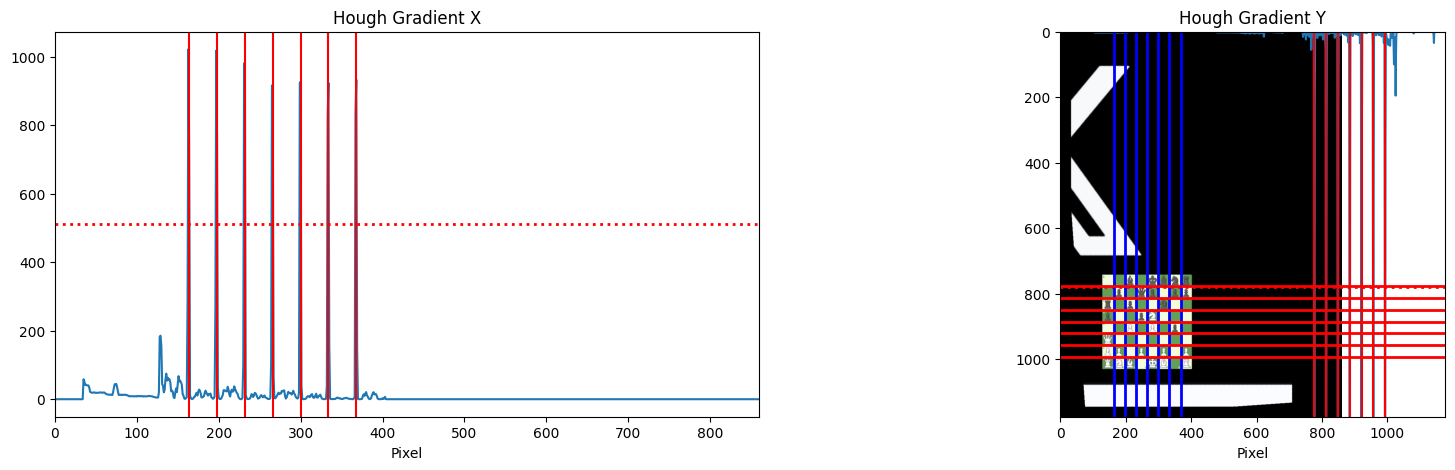

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(hough_Dx_val)
ax1.axhline(hough_Dx_thresh_val, lw=2, linestyle=":", color="r")
ax1.set_title("Hough Gradient X")
ax1.set_xlabel("Pixel")
ax1.set_xlim(0, a.shape[1])

ax2.plot(hough_Dy_val)
ax2.axhline(hough_Dy_thresh_val, lw=2, linestyle=":", color="r")
ax2.set_title("Hough Gradient Y")
ax2.set_xlim(0, a.shape[0])
ax2.set_xlabel("Pixel")

if len(lines_x) < 20:
    for hx in lines_x:
        ax1.axvline(hx, color="r")
if len(lines_y) < 20:
    for hy in lines_y:
        ax2.axvline(hy, color="r")

plt.imshow(img)
for hx in lines_x:
    plt.axvline(hx, color="b", lw=2)
for hy in lines_y:
    plt.axhline(hy, color="r", lw=2)

X (vertical) [164 198 232 266 300 334 368] [34 34 34 34 34 34]
Y (horizontal) [777 813 849 885 921 957 993] [36 36 36 36 36 36]
7 horizontal and vertical lines found, slicing up squares
Tiles generated: (36x34)*64


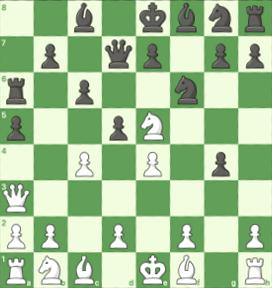

In [35]:
print("X (vertical)", lines_x, np.diff(lines_x))
print("Y (horizontal)", lines_y, np.diff(lines_y))

if is_match:
    print("7 horizontal and vertical lines found, slicing up squares")
    squares = get_chess_tiles(a, lines_x, lines_y)
    print(
        f"Tiles generated: ({squares.shape[0]}x{squares.shape[1]})*{squares.shape[2]}"
    )
    chessboard_img = extract_chessboard(img, lines_x, lines_y)
    display_array(np.asarray(chessboard_img), rng=[0, 255])
else:
    print("Number of lines not equal to 7")